figure = 66.66
bottle = 62.96
pen = 54.54

In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from metrics_utils import * 
from infer_utils import * 

xFormers not available
xFormers not available


In [2]:
IMAGE_SIZE = 1120 
PATCH_DIM = IMAGE_SIZE //14
IDX = 3 #id of the object in the category

In [3]:
split_train = r"Bottle_train/"
split_test = r"Bottle_train/"

## Init the Valid Input Point Model 

In [4]:
args_infer = {
    "model_path" : "runs/bottle_1_single.ckpt",
    "device" : "cuda",
    "img_size" : IMAGE_SIZE
}

In [12]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128,input_cls=1)
dataset_train = JacquardSamples(dataset_root= split_train ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=4)
dataset = JacquardSamples(dataset_root= split_test ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=7)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for BCEGraspTransformer:
	size mismatch for dinov2d_backbone.cls_token: copying a param with shape torch.Size([1, 1, 384]) from checkpoint, the shape in current model is torch.Size([1, 1, 768]).
	size mismatch for dinov2d_backbone.pos_embed: copying a param with shape torch.Size([1, 1370, 384]) from checkpoint, the shape in current model is torch.Size([1, 1370, 768]).
	size mismatch for dinov2d_backbone.mask_token: copying a param with shape torch.Size([1, 384]) from checkpoint, the shape in current model is torch.Size([1, 768]).
	size mismatch for dinov2d_backbone.patch_embed.proj.weight: copying a param with shape torch.Size([384, 3, 14, 14]) from checkpoint, the shape in current model is torch.Size([768, 3, 14, 14]).
	size mismatch for dinov2d_backbone.patch_embed.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.0.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.0.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.0.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.1.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.1.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.1.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.2.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.2.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.2.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.3.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.3.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.3.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.4.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.4.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.4.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.5.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.5.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.5.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.6.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.6.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.6.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.6.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.6.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.6.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.6.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.7.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.7.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.7.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.7.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.7.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.7.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.7.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.8.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.8.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.8.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.8.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.8.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.8.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.8.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.9.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.9.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.9.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.9.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.9.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.9.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.9.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.10.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.10.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.10.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.10.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.10.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.10.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.10.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for dinov2d_backbone.blocks.11.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for dinov2d_backbone.blocks.11.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for dinov2d_backbone.blocks.11.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.ls1.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.mlp.fc1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for dinov2d_backbone.blocks.11.mlp.fc1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for dinov2d_backbone.blocks.11.mlp.fc2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for dinov2d_backbone.blocks.11.mlp.fc2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.blocks.11.ls2.gamma: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for dinov2d_backbone.norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for linear_head.0.weight: copying a param with shape torch.Size([256, 384]) from checkpoint, the shape in current model is torch.Size([256, 768]).

## Init the Second Point Model 

In [13]:
args_infer_single = {
    "model_path" : "runs/bottle_1_double.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}


In [14]:
device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model_single = BCEGraspTransformer(img_size=args_infer_single["img_size"],int_dim=256,output_dim=32)
model_single.load_state_dict(torch.load(args_infer_single["model_path"]))
model_single = model_single.to(device)

In [15]:
constrain_mode = True
TOPK = True
topk_grasps = 1
topk_input = 50

In [9]:
max_dist =0
min_dist = 999999
for i in range(len(dataset_train)):
    data = dataset_train[i]
    img = data["img"].to(device)
    img = torch.permute(img, (0, 2, 1))
    mask = data["mask"].sum().sqrt()
    all_points = torch.tensor(data["points_grasp"]//14)
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min() and dif_n.min()>0:
        min_dist = dif_n.min()
if min_dist < 0.01:
    min_dist = 0.01

C:\Users\49174\Desktop\prak_proj\ZeroShot-Grasping\MLP-approach\dataset_jacquard_samples.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
C:\Users\49174\Desktop\prak_proj\ZeroShot-Grasping\MLP-approach\dataset_jacquard_samples.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)
C:\Users\49174\AppData\Local\Temp\ipykernel_7700\3396165159.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_points = torch.tensor(data["points_grasp"]

In [10]:
print(min_dist)

tensor(0.0167)


In [11]:
print(len(dataset))

17


### Loop over the data and get the metrics

In [ ]:
accuracies = []
for test_idx in range(1): 
    test_idx = 13
    data = dataset[test_idx]
    img = data["img"].to(device)
    mask = data["mask"].to(device)
    img = torch.permute(img, (0, 2, 1))
    grasp = data["points_grasp"]//14
    normal_grasp = grasp.clone()
    grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
    grasp = torch.cat([grasp, grasp_inv], dim=0)
    #get features from dino
    features,_ = model.forward_dino_features(img.unsqueeze(0))
    features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 768)

    #plt.figure(figsize=(16,16))
    org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
    #plt.imshow(org_image)


    ## get valid points
    all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)


    preds, preds_patches = get_valid_points(all_points, features, model, device,PATCH_DIM=PATCH_DIM)

    preds_cp, pts, valid_pts_pred = get_topk_valid_points(preds,preds_patches, mask, topk_num=topk_input,TOP_K=TOPK)

    #get second point informations 
    mask, mask_n, _, _, grasp, heights, corners = get_second_point_data(dataset,4,model_single,device,args_infer, inv_transform,test_idx=test_idx)

    num_grasps = valid_pts_pred.shape[0]
    #objs = 1


    data = {}
    data['mask'] = mask
    data['valid_pts_pred'] = valid_pts_pred
    data['min_dist'] = min_dist
    data['max_dist'] = max_dist
    data['heights'] = heights 
    data['args_infer'] = args_infer
    data['mask_n'] = mask_n
    data['device'] = device
    data['features'] = features
    data['model_single'] = model_single

    ##currently only support constraint mode == false
    items = get_predictions(num_grasps,data,constrain_mode=constrain_mode)
    try:
        cur_accuracy = vis_preds_with_metrics(num_grasps, items, org_image, grasp,heights, args_infer,preds_cp,topks=topk_grasps)
        accuracies.append(cur_accuracy)
    except:
        accuracies.append(0.)
    

    print('Object accuracy is', sum(accuracies)/len(accuracies))



In [15]:
print(org_image.shape)

(1120, 1120, 3)


In [20]:
print(torch.unique(preds))

tensor([0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


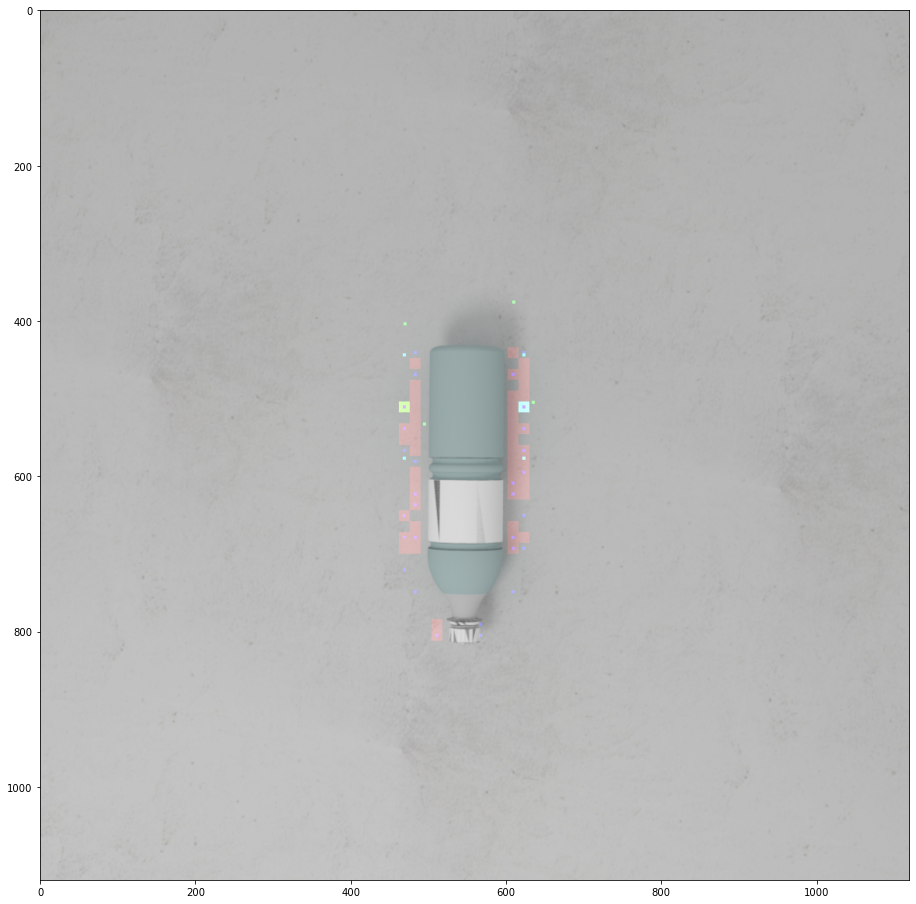

In [22]:
plt.figure(figsize=(16,16))
plt.imshow(org_image + origin_point*0.7)